$\min f(x)=\max _{1 \leq i \leq 6} f_{i}(x)$


$\begin{aligned} f_{1}(x)=& x_{1}^{2}+x_{2}^{2}+x_{1} x_{2}-14 x_{1}-16 x_{2}+\left(x_{3}-10\right)^{2} \\ &+4\left(x_{4}-5\right)^{2}+\left(x_{5}-3\right)^{2}+2\left(x_{6}-1\right)^{2}+5 x_{7}^{2} \\ &+7\left(x_{8}-11\right)^{2}+2\left(x_{9}-10\right)^{2}+\left(x_{10}-7\right)^{2}+45, \\ f_{2}(x)=& f_{1}(x)+10\left(3\left(x_{1}-2\right)^{2} \ldots\right.\\ &\left.+4\left(x_{2}-3\right)^{2}+2 x_{3}^{2}-7 x_{4}-120\right), \\ f_{3}(x)=& f_{1}(x)+10\left(5 x_{1}^{2}+8 x_{2}+\left(x_{3}-6\right)^{2}-2 x_{4}-40\right), \\ f_{4}(x)=& f_{1}(x)+10\left(0.5\left(x_{1}-8\right)^{2} \cdots\right.\\ &\left.+2\left(x_{2}-4\right)^{2}+3 x_{5}^{2}-x_{6}-30\right), \\ f_{5}(x)=& f_{1}(x)+10\left(x_{1}^{2}+2\left(x_{2}-2\right)^{2}\right.\\ &\left.-2 x_{1} x_{2}+14 x_{5}-6 x_{6}\right), \\ f_{6}(x)=& f_{1}(x)+10\left(-3 x_{1}+6 x_{2}+12\left(x_{9}-8\right)^{2}-7 x_{10}\right), \\ g_{1}(x)=& 4 x_{1}+5 x_{2}-3 x_{7}+9 x_{8}-105, \\ g_{2}(x)=& 10 x_{1}-8 x_{2}-17 x_{7}+2 x_{8}, \\ g_{3}(x)=&-8 x_{1}+2 x_{2}+5 x_{9}-2 x_{10}-12 . \end{aligned}$

In [ ]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
from numpy.linalg import inv

class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs

        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

class weightedcustom(ODEF):
    def __init__(self,A1,A2,A3,A4,A5,A6):
        super(weightedcustom,self).__init__()
        self.A1 = nn.Parameter(A1)
        self.A2 = nn.Parameter(A2)
        self.A3 = nn.Parameter(A3)
        self.A4 = nn.Parameter(A4)
        self.A5 = nn.Parameter(A5)
        self.A6 = nn.Parameter(A6)
    def f1(self,x):
        return x[0]**2 + x[1]**2 + x[0]*x[1] - 14*x[0] - 16*x[1] + (x[2]-10)**2 + 4*(x[3]-5)**2 + (x[4]-3)**2 + 2*(x[5]-1)**2 + 5*x[6]**2 + 7*(x[7]-11)**2 + 2*(x[8]-10)**2 + (x[9]-7)**2 + 45
    def f2(self,x):
        return self.f1(x) + 10*(3*(x[0]-2)**2 + 4*(x[1]-3)**3 + 2*x[2]**2 - 7*x[3]*2 -120)
    def f3(self,x):
        return self.f1(x) + 10*(5*x[0]**2 + 8*x[1] + (x[2]-6)**2 - 2*x[3] - 40 )
    def f4(self,x):
        return self.f1(x) + 10*(0.5*(x[0]-8)**2 + 2*(x[1]-4)**2 + 3*x[4]**2 - x[5] - 30)
    def f5(self,x):
        return self.f1(x) + 10*(x[0]**2 + 2*(x[1]-2)**2 - 2*x[0]*x[1] + 14*x[4] - 6*x[5])
    def f6(self,x):
        return self.f1(x)  + 10*(-3*x[0] + 6*x[1] + 12*(x[8]-8)**2 - 7*x[9])
    def g1(self,x):
        return 4*x[0] + 5*x[1] - 3*x[6] + 9*x[7] - 105
    def g2(self,x):
        return 10*x[0] - 8*x[1] - 17*x[6] + 2*x[7] 
    def g3(self,x):
        return (-8)*x[0] + 2*x[1] + 5*x[8] - 2*x[9] - 12
    def sign(self,g):
        if g>0:
            return 1
        elif g<0:
            return 0
        else:
            p = np.random.rand()
            return p
    def forward(self, x, t):
        C1 = Tensor([[4,5,0,0,0,0,-3,9,0,0]])
        C2 = Tensor([[10,-8,0,0,0,0,-17,2,0,0]])
        C3 = Tensor([[-8,2,0,0,0,0,0,0,5,-2]])
        B1 = Tensor([[14,16,20,40,6,4,0,154,40,14]])
        B2 = B1 + Tensor([[120,240,0,70,0,0,0,0,0,0]])
        B3 = B1 + Tensor([[0,-80,120,20,0,0,0,0,0,0]])
        B4 = B1 + Tensor([[80,160,0,0,0,10,0,0,0,0]])
        B5 = B1 + Tensor([[0,80,0,0,-140,60,0,0,0,0]])
        B6 = B1 + Tensor([[30,-60,0,0,0,0,0,0,1920,70]])
        p = 1.0
        index = []
        index.append(self.f1(x[0]).item())
        index.append(self.f2(x[0]).item())
        index.append(self.f3(x[0]).item())
        index.append(self.f4(x[0]).item())
        index.append(self.f5(x[0]).item())
        index.append(self.f6(x[0]).item())
        i = np.argmax(np.array(index))
        if i==0:
            ex = (1-self.sign(self.g1(x[0])))*(1-self.sign(self.g2(x[0])))*(torch.mm(x,(self.A1 ).T) - B1)
        elif i==1:
            ex = (1-self.sign(self.g1(x[0])))*(1-self.sign(self.g2(x[0])))*(torch.mm(x,(self.A2).T) - B2)
        elif i==2:
            ex = (1-self.sign(self.g1(x[0])))*(1-self.sign(self.g2(x[0])))*(torch.mm(x,(self.A3 ).T) - B3)
        elif i==3:
            ex = (1-self.sign(self.g1(x[0])))*(1-self.sign(self.g2(x[0])))*(torch.mm(x,(self.A4 ).T) - B4)
        elif i==4:
            ex = (1-self.sign(self.g1(x[0])))*(1-self.sign(self.g2(x[0])))*(torch.mm(x,(self.A5 ).T) - B5)
        elif i==5:
            ex = (1-self.sign(self.g1(x[0])))*(1-self.sign(self.g2(x[0])))*(torch.mm(x,(self.A6 ).T) - B6)

        ex += self.sign(self.g1(x[0]))*C1
        ex += self.sign(self.g2(x[0]))*C2
        ex += self.sign(self.g3(x[0]))*C3
        return -ex


class SpiralFunctionTest(weightedcustom):
    def __init__(self):
        A1 = Tensor([[2,1,0,0,0,0,0,0,0,0],
            [1,2,0,0,0,0,0,0,0,0],
            [0,0,2,0,0,0,0,0,0,0],
            [0,0,0,8,0,0,0,0,0,0],
            [0,0,0,0,2,0,0,0,0,0],
            [0,0,0,0,0,4,0,0,0,0],
            [0,0,0,0,0,0,10,0,0,0],
            [0,0,0,0,0,0,0,14,0,0],
            [0,0,0,0,0,0,0,0,4,0],
            [0,0,0,0,0,0,0,0,0,2]])
        A2 = Tensor([[60,0,0,0,0,0,0,0,0,0],
                        [0,80,0,0,0,0,0,0,0,0],
                        [0,0,40,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0]])
        A3 = Tensor([[100,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,20,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0]])
        A4 = Tensor([[20,0,0,0,0,0,0,0,0,0],
                        [0,40,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,60,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0]])
        A5 = Tensor([[20,-20,0,0,0,0,0,0,0,0],
                        [-20,40,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0]])
        A6 = Tensor([[0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,240,0],
                        [0,0,0,0,0,0,0,0,0,0]])

        super(SpiralFunctionTest, self).__init__(A1,A2,A3,A4,A5,A6)
def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.001
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0
    
    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z
def ode_solve1(z0, t0, t1, f):
    """
    Simplest RK4 ODE initial value solver
    """
    h_max = 0.001
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0
    # print(h)
    # h=Tensor([[0.001]])
    for i_step in range(n_steps):
        k1 = h*f(z, t)
        k2 = h * (f((z+h/2), (z+k1/2)))
        k3 = h * (f((z+h/2), (z+k2/2)))
        k4 = h * (f((z+h), (z+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        z = z + k
        t = t + h
    return z
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        # print("ccccccheck",z0)
        # print(self.func)
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        
        if return_whole_sequence:
            return z
        else:
            return z[-1]
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            #print(time_len)
            z[0] = z0
            for i_t in range(time_len - 1):
                #print(z[0],t[i_t],t[i_t+1], func)
                #z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z0 = ode_solve1(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

def conduct_experiment(ode_true):
    time=[]
    # Create data
    #z0 = Variable(torch.Tensor([[0.6, 0.3]]))
    #z0 = Variable(torch.Tensor([[4.2,3.5,6.3,5.4,0.5,8.6,1.7,7.8,7.9,5.5]]))
    
    z0 = Variable(torch.Tensor([[5,6,7,8,9,10,11,12,13,14]]))
    #z0 = Variable(torch.Tensor([[2,3,5,5,1,2,7,3,6,10]]))
    t_max = 6.29*5
    n_points = 100

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    time.append(times)
    return obs,time
ode_true = NeuralODE(SpiralFunctionTest())
def train(ode_true,z_init):
    time=[]
    time_arrs=[]
    sols = []
    # Create data    
    # z_init = [Variable(torch.randn(1, 3)) for i in range(num)]
    for z_0 in z_init:
        t_max = 6.29*5
        n_points = 100

        index_np = np.arange(0, n_points, 1, dtype=np.int)
        index_np = np.hstack([index_np[:, None]])
        times_np = np.linspace(0, t_max, num=n_points)
        times_np = np.hstack([times_np[:, None]])

        times = torch.from_numpy(times_np[:, :, None]).to(z_0)
        obs = ode_true(z_0, times, return_whole_sequence=True).detach()
        time.append(times)

        sol_arr = obs.cpu().detach().numpy()
        time_arr = time[0].cpu().detach().numpy()
        Z=[]
        for i in range(10):
            z=sol_arr[:,:,i].reshape(-1).tolist()
            Z.append(z)
        sols.append(Z)
        time_arrs.append(time_arr)
    t=time_arrs[0][:,:,0].reshape(-1).tolist()
    plt.figure(figsize=(20,15))
    plt.rcParams.update({'font.size': 16})
    for i in range(len(z_init)):
        #if i==0:
        plt.plot(t, sols[i][0][:],color='red',label=r'$x_{1}(t)$',linewidth=1)
        plt.plot(t, sols[i][1][:],color='green',label=r'$x_{2}(t)$',linewidth=1)
        plt.plot(t, sols[i][2][:],color='blue',label=r'$x_{3}(t)$',linewidth=1)
        plt.plot(t, sols[i][3][:],color='orange',label=r'$x_{4}(t)$',linewidth=1)
        plt.plot(t, sols[i][4][:],color='purple',label=r'$x_{5}(t)$',linewidth=1)
        plt.plot(t, sols[i][5][:],color='brown',label=r'$x_{6}(t)$',linewidth=1)
        plt.plot(t, sols[i][6][:],color='pink',label=r'$x_{7}(t)$',linewidth=1)
        plt.plot(t, sols[i][7][:],color='gray',label=r'$x_{8}(t)$',linewidth=1)
        plt.plot(t, sols[i][8][:],color='olive',label=r'$x_{9}(t)$',linewidth=1)
        plt.plot(t, sols[i][9][:],color='cyan',label=r'$x_{10}(t)$',linewidth=1)

        # else:
        #     plt.plot(t, sols[i][0][:],color='r',linewidth=4)
        #     plt.plot(t, sols[i][1][:],color='g',linewidth=4)
        #     plt.plot(t, sols[i][2][:],color='b',linewidth=4)
    plt.xlabel('time / depth')
    plt.ylabel('x(t)')
    plt.legend([r'$x_{1}(t)$',r'$x_{2}(t)$',r'$x_{3}(t)$',r'$x_{4}(t)$',r'$x_{5}(t)$',r'$x_{6}(t)$',r'$x_{7}(t)$',r'$x_{8}(t)$',r'$x_{9}(t)$',r'$x_{10}(t)$'])
    plt.savefig("output/result1.png")
    clear_output(wait=True)



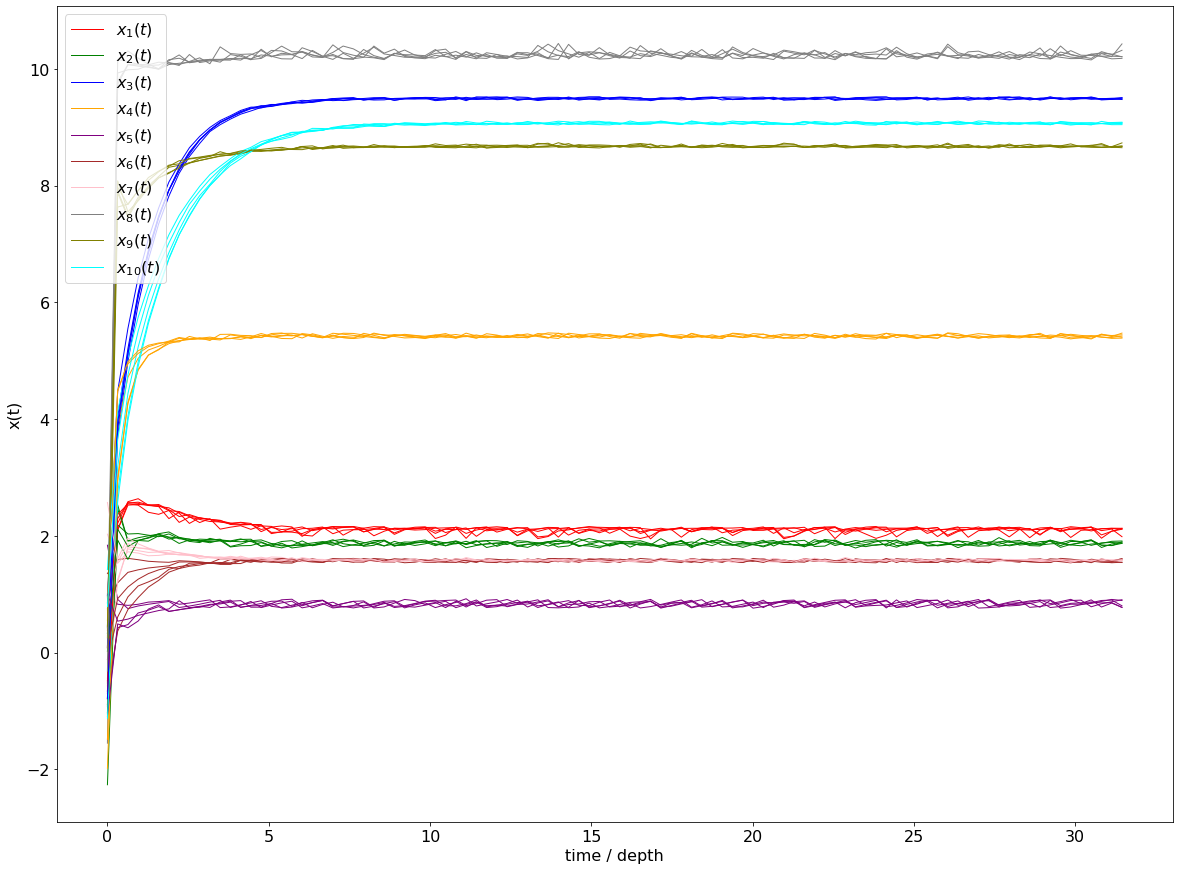

In [4]:

count=5
z_init = [Variable(torch.randn(1, 10)) for i in range(count)]
train(ode_true,z_init)

Text(0.5, 0, 'time / depth')

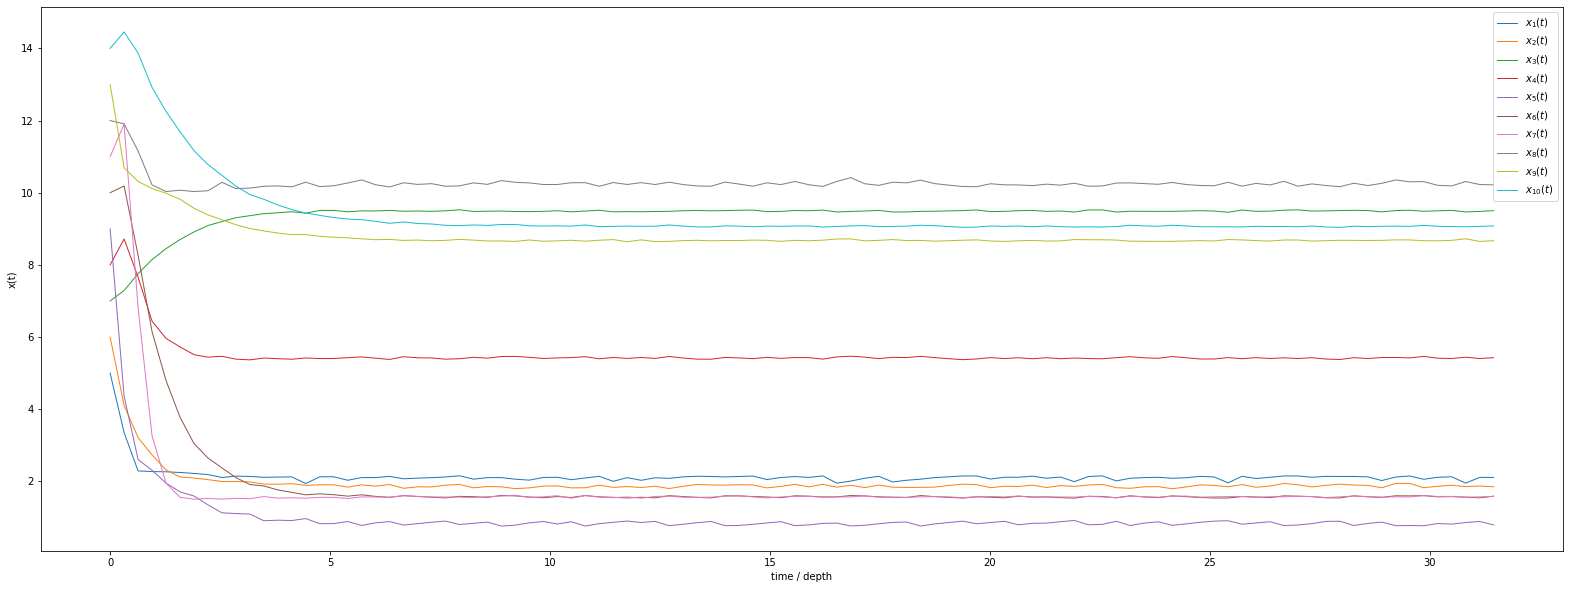

In [15]:

sol,time = conduct_experiment(ode_true)
sol_arr = sol.cpu().detach().numpy()
time_arr = time[0].cpu().detach().numpy()
Z=[]
for i in range(10):
    z=sol_arr[:,:,i].reshape(-1).tolist()
    Z.append(z)
t=time_arr[:,:,0].reshape(-1).tolist()
fig = plt.figure(figsize=(60,10))
ax = fig.add_subplot(121)
# for i in range(10):
#     ax.plot(t, Z[i][:],label=f"x_{i}", lw=1)
#     #ax.plot(t, Z[i][:],label=r'$x_{i}$', lw=1)
ax.plot(t, Z[0][:],label=r'$x_{1}(t)$', lw=1)
ax.plot(t, Z[1][:],label=r'$x_{2}(t)$', lw=1)
ax.plot(t, Z[2][:],label=r'$x_{3}(t)$', lw=1)
ax.plot(t, Z[3][:],label=r'$x_{4}(t)$', lw=1)
ax.plot(t, Z[4][:],label=r'$x_{5}(t)$', lw=1)
ax.plot(t, Z[5][:],label=r'$x_{6}(t)$', lw=1)
ax.plot(t, Z[6][:],label=r'$x_{7}(t)$', lw=1)
ax.plot(t, Z[7][:],label=r'$x_{8}(t)$', lw=1)
ax.plot(t, Z[8][:],label=r'$x_{9}(t)$', lw=1)
ax.plot(t, Z[9][:],label=r'$x_{10}(t)$', lw=1)
ax.legend()
ax.set_ylabel('x(t)')
ax.set_xlabel('time / depth')

$$
\begin{array}{ll}
\min & f(x)=\frac{x^{T} Q x+a^{T} x+a_{0}}{c^{T} x+c_{0}} \\
\text { s.t. } & x_{1}+x_{2}-x_{3}=3 \\
& x_{1}-2 x_{2}+x_{4}=0 \\
& x_{1}^{2}+2 x_{2}^{4}-x_{3} \leq 10 \\
& -x_{1}-x_{2}-x_{3}+x_{4} \leq 5 \\
& x_{2}^{2}-2 x_{1} x_{2}+x_{3}+x_{4}^{2} \leq 10 \\
& x_{1}^{2}+x_{2}^{2}+x_{3}^{2} \leq 5
\end{array}
$$
where
$$
\begin{aligned}
&Q=\left(\begin{array}{cccc}
-1 & 0.5 & 1 & 0 \\
0.5 & 5.5 & -1 & -0.5 \\
1 & -1 & 1 & 0 \\
0 & -0.5 & 0 & 0
\end{array}\right), \quad a=\left(\begin{array}{c}
1 \\
-1 \\
-1 \\
1
\end{array}\right) \\
&a_{0}=-2, \\
&c=(1,1,1,-1)^{T}, \quad c_{0}=6
\end{aligned}
$$

In [ ]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm
from tqdm import tqdm
import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
from numpy.linalg import inv

class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs

        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

class weightedcustom(ODEF):
    def __init__(self,theta=123):
        super(weightedcustom,self).__init__()
        self.theta = theta
    def h1(self,x):
        return x[0]+x[1]-x[2]-3
    def h2(self,x):
        return x[0]-2*x[1]+x[3]
    def g1(self,x):
        return x[0]**2 + 2*(x[1]**4) - x[2] -10
    def g2(self,x):
        return -x[0] - x[1] - x[2] + x[3] -5
    def g3(self,x):
        return x[1]**2 - 2*x[0]*x[1] + x[2] + x[3]**2 - 10
    def g4(self,x):
        return x[0]**2 + x[1]**2 + x[2]**2  -5
    def sign(self,g):
        if g>0:
            return 1
        elif g<0:
            return -1
        else:
            p = np.random.rand()
            return p
    def forward(self, x, t):
        Q = Tensor([[-1,0.5,1,0],
                    [0.5,5.5,-1,-0.5],
                    [1,-1,1,0],
                    [0,-0.5,0,0]])
        a = Tensor([[1,-1,-1,1]])
        a0 = -2
        c = Tensor([[1,1,1,-1]])
        c0 = 6
        ex = ((a+torch.mm(x,Q)*2)*(torch.mm(x,c.T)+c0) - (a0+torch.mm(x,a.T)+torch.mm((torch.mm(x,Q)),x.T)) *c)/((torch.mm(x,c.T)+c0)**2)
        index = []
        if torch.abs(torch.abs(self.h1(x[0]))-torch.abs(self.h2(x[0])))<1e-2:
            if x[0][0]+x[0][1]-x[0][2]>=0 and x[0][0]-2*x[0][1]+x[0][3]>=0:
                A = [1,-1/2,-1/2,1/2]
                ex += self.theta*Tensor([A])
            elif x[0][0]+x[0][1]-x[0][2]>=0 and x[0][0]-2*x[0][1]+x[0][3]<0:
                A = [0,3/2,-1/2,-1/2]
                ex += self.theta*Tensor([A])
            elif x[0][0]+x[0][1]-x[0][2]<0 and x[0][0]-2*x[0][1]+x[0][3]>=0:
                A = [0,-3/2,1/2,1/2]
                ex += self.theta*Tensor([A])
        else:
            index.append(torch.abs(self.h1(x[0])).item())
            index.append(torch.abs(self.h2(x[0])).item())
            i = np.argmax(np.array(index))
            if i==0:
                A = []
                if x[0][0]+x[0][1]-x[0][2]-3>=0:
                    A = [1,1,-1,0]
                else:
                    A = [-1,-1,1,0]
                ex += self.theta*Tensor([A])
            elif i==1:
                A = []
                if x[0][0]-2*x[0][1]+x[0][3]>=0:
                    A = [1,-2,0,1]
                else:
                    A = [-1,2,0,-1]
                ex += self.theta*Tensor([A])
        index1 = []
        index1.append(self.g1(x[0]).item())
        index1.append(self.g2(x[0]).item())
        index1.append(self.g3(x[0]).item())
        index1.append(self.g4(x[0]).item())
        j = np.argmax(np.array(index1))

        if j==0:
            if self.g1(x[0])>0:
                B = [2*(x[0][0].item()),8*((x[0][1]**3).item()),-1,0]
                ex += self.theta*Tensor([B])
        elif j==1:
            if self.g2(x[0])>0:
                B = [-1,-1,-1,1]
                ex += self.theta*Tensor([B])
        elif j==2:
            if self.g3(x[0])>0:
                B = [-2*(x[0][1].item()),2*(x[0][1].item())-2*(x[0][0].item()),1,2*(x[0][3].item())]
                ex += self.theta*Tensor([B])
        elif j==3:
            if self.g3(x[0])>0:
                B = [2*(x[0][0].item()),2*(x[0][1].item()),2*(x[0][2].item()),0]
                ex += self.theta*Tensor([B])
        return -ex


class SpiralFunctionTest(weightedcustom):
    def __init__(self,theta):
        super(SpiralFunctionTest, self).__init__(theta)
def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.001
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0
    h=Tensor([[0.0001]])
    for i_step in range(n_steps):

        z = z + h * f(z, t)
        #print(z)
        t = t + h
    return z
def ode_solve1(z0, t0, t1, f):
    """
    Simplest RK4 ODE initial value solver
    """
    h_max = 0.001
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0
    h=Tensor([[0.0001]])
    for i_step in range(n_steps):
        k1 = h*f(z, t)
        k2 = h * (f((z+h/2), (z+k1/2)))
        k3 = h * (f((z+h/2), (z+k2/2)))
        k4 = h * (f((z+h), (z+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        z = z + k
        
        t = t + h
    return z
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func)
        
        if return_whole_sequence:
            return z
        else:
            return z[-1]
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                #z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z0 = ode_solve1(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0
                if RMSELoss(z0,z[i_t])<1e-4:
                    print(i_t)
                    break
        ctx.func = func
        return z
def conduct_experiment(ode_true):
    time=[]
    # Create data
    #z0 = Variable(torch.Tensor([[0.6, 0.3]]))
    #z0 = Variable(torch.Tensor([[4.2,3.5,6.3,5.4,0.5,8.6,1.7,7.8,7.9,5.5]]))
    
    z0 = Variable(torch.Tensor([[1,1,-1,1]]))
    #z0 = Variable(torch.Tensor([[2.0598, -0.4858, -1.4260, -3.0313]]))
    #z0 = torch.tensor([[4.,1.,-3.,1.]], requires_grad=True)
    t_max = 200
    n_points = 100

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    time.append(times)
    return obs,time
def train(ode_true,count,z_init):
    time=[]
    time_arrs=[]
    sols = []
    # Create data    
    # z_init = [Variable(torch.randn(1, 3)) for i in range(num)]
    for z_0 in z_init:
        t_max = 20
        n_points = 100

        index_np = np.arange(0, n_points, 1, dtype=np.int)
        index_np = np.hstack([index_np[:, None]])
        times_np = np.linspace(0, t_max, num=n_points)
        times_np = np.hstack([times_np[:, None]])

        times = torch.from_numpy(times_np[:, :, None]).to(z_0)
        obs = ode_true(z_0, times, return_whole_sequence=True).detach()
        time.append(times)

        sol_arr = obs.cpu().detach().numpy()
        time_arr = time[0].cpu().detach().numpy()
        Z=[]
        for i in range(3):
            z=sol_arr[:,:,i].reshape(-1).tolist()
            Z.append(z)
        sols.append(Z)
        time_arrs.append(time_arr)
    t=time_arrs[0][:,:,0].reshape(-1).tolist()
    plt.figure(figsize=(20,15))
    plt.rcParams.update({'font.size': 16})
    for i in range(len(z_init)):
        #if i==0:
        plt.plot(t, sols[i][0][:],color='r',label=r'$x_{1}(t)$',linewidth=1)
        plt.plot(t, sols[i][1][:],color='g',label=r'$x_{2}(t)$',linewidth=1)
        plt.plot(t, sols[i][2][:],color='b',label=r'$x_{3}(t)$',linewidth=1)
        # else:
        #     plt.plot(t, sols[i][0][:],color='r',linewidth=4)
        #     plt.plot(t, sols[i][1][:],color='g',linewidth=4)
        #     plt.plot(t, sols[i][2][:],color='b',linewidth=4)
    plt.xlabel('time / depth')
    plt.ylabel('x(t)')
    plt.legend([r'$x_{1}(t)$',r'$x_{2}(t)$',r'$x_{3}(t)$'])
    plt.savefig("output/theta_"+str(count)+".png")
    clear_output(wait=True)




In [ ]:

theta_s =  range(25,201,25)
ode_trues = []

for i in theta_s:
    
    ode_trues.append(NeuralODE(SpiralFunctionTest(theta=i)))
count=5
z_init = [Variable(torch.randn(1, 3)) for i in range(count)]
for func,num in tqdm(zip(ode_trues,theta_s)):
    conduct_experiment(func,num,z_init)
    print("Done!")

In [ ]:
ode_true = NeuralODE(SpiralFunctionTest(theta=158))
sol,time = conduct_experiment(ode_true) 

In [ ]:
sol_arr = sol.cpu().detach().numpy()
time_arr = time[0].cpu().detach().numpy()
Z=[]
for i in range(4):
    z=sol_arr[:,:,i].reshape(-1).tolist()
    Z.append(z)
t=time_arr[:,:,0].reshape(-1).tolist()
fig = plt.figure(figsize=(60,10))
ax = fig.add_subplot(121)
ax.plot(t, Z[0][:],label=r'$x_{1}(t)$', lw=1)
ax.plot(t, Z[1][:],label=r'$x_{2}(t)$', lw=1)
ax.plot(t, Z[2][:],label=r'$x_{3}(t)$', lw=1)
ax.plot(t, Z[3][:],label=r'$x_{4}(t)$', lw=1)
ax.legend()
ax.set_ylabel('x(t)')
ax.set_xlabel('time / depth')

$\min f(x) = \dfrac{x^TQx+ax+a_0}{cx+c_0}$
 $$st: \begin{cases} Ax \le b\\ x \in \Omega\end{cases}$$
where
$$ Q = \begin{bmatrix} 5 & -1 & 2 & 0 \\ -1 & 5 & -1 & 3 \\ 2 & -1 & 3 & 0 \\ 0 & 3 & 0 & 5    \end{bmatrix}, a = \begin{bmatrix} 1\\ -2 \\ -2 \\ 1 \end{bmatrix}, c = \begin{bmatrix} 2\\ 1 \\ 1 \\ 0 \end{bmatrix},a_0=-2,c_0=4, A = \begin{bmatrix} 1 & -1 & 0 & 0 \\  0 & 0 & 1 & -1    \end{bmatrix}, b = \begin{bmatrix} 1\\2   \end{bmatrix} $$
and
$\Omega = \{x\in \mathbf{R^4} : 5\le x_i \le 10, i=1,2,3,4\}$

In [ ]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm
import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
from numpy.linalg import inv
use_cuda = torch.cuda.is_available()
class weightedcustom(nn.Module):
    def __init__(self,theta=123):
        super(weightedcustom,self).__init__()
        self.theta = theta
    def h1(self,x):
        return x[0]-x[1]-1
    def h2(self,x):
        return x[2]-x[3]-2
    def g1(self,x):
        return x[0]-10
    def g2(self,x):
        return x[1]-10
    def g3(self,x):
        return x[2]-10
    def g4(self,x):
        return x[3]-10
    def g5(self,x):
        return 5-x[0]
    def g6(self,x):
        return 5-x[1]
    def g7(self,x):
        return 5-x[2]
    def g8(self,x):
        return 5-x[3]
    def forward(self, x, t):
        Q = Tensor([[5,-1,2,0],
                    [-1,5,-1,3],
                    [2,-1,3,0],
                    [0,3,0,5]])
        a = Tensor([[1,-2,-2,1]])
        a0 = -2
        c = Tensor([[2,1,1,0]])
        c0 = 4
        
        with torch.set_grad_enabled(True):
            x.requires_grad=True
            #x = x.to('cuda')
            x.retain_grad()
            #print(x)
            f = (torch.mm((torch.mm(x,Q)),x.T)+a0+torch.mm(x,a.T))/(torch.mm(x,c.T)+c0)
            index = []
            index.append(torch.abs(self.h1(x[0])).item())
            index.append(torch.abs(self.h2(x[0])).item())
            i = np.argmax(np.array(index))
            if i==0:
                A = []
                if x[0][0]-x[0][1]-1>=0:
                    A = [1,-1,0,0]
                else:
                    A = [-1,1,0,0]
                f += self.theta*torch.mm(x,(Tensor([A])).T)
            elif i==1:
                A = []
                if x[0][2]-x[0][3]-2>=0:
                    A = [0,0,1,-1]
                else:
                    A = [0,0,-1,1]
                f += self.theta*torch.mm(x,(Tensor([A])).T)
            
            index1 = [0]
            index1.append(self.g1(x[0]).item())
            index1.append(self.g2(x[0]).item())
            index1.append(self.g3(x[0]).item())
            index1.append(self.g4(x[0]).item())
            index1.append(self.g5(x[0]).item())
            index1.append(self.g6(x[0]).item())
            index1.append(self.g7(x[0]).item())
            index1.append(self.g8(x[0]).item())
            j = np.argmax(np.array(index1))

            if j!=0:
                if j==1:
                    B = [1,0,0,0]
                    f += self.theta*torch.mm(x,(Tensor([B])).T)
                elif j==2:
                    B = [0,1,0,0]
                    f += self.theta*torch.mm(x,(Tensor([B])).T)
                elif j==3:
                    B = [0,0,1,0]
                    f += self.theta*torch.mm(x,(Tensor([B])).T)
                elif j==4:
                    B = [0,0,0,1]
                    f += self.theta*torch.mm(x,(Tensor([B])).T)
                if j==5:
                    B = [-1,0,0,0]
                    f += self.theta*torch.mm(x,(Tensor([B])).T)
                elif j==6:
                    B = [0,-1,0,0]
                    f += self.theta*torch.mm(x,(Tensor([B])).T)
                elif j==7:
                    B = [0,0,-1,0]
                    f += self.theta*torch.mm(x,(Tensor([B])).T)
                elif j==8:
                    B = [0,0,0,-1]
                    f += self.theta*torch.mm(x,(Tensor([B])).T)
            f.backward(retain_graph=True)
            return -x.grad

def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.001
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0
    h=Tensor([[0.0001]]).to('cuda')
    for i_step in range(n_steps):

        z = z + h * f(z, t)
        #print(z)
        t = t + h
    return z
def ode_solve1(z0, t0, t1, f):
    """
    Simplest RK4 ODE initial value solver
    """
    h_max = 0.001
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    h=Tensor([[0.0001]])
    #print(n_steps)
    for i_step in range(n_steps):
        k1 = h*f(z, t)
        k2 = h * (f((z+h/2), (z+k1/2)))
        k3 = h * (f((z+h/2), (z+k2/2)))
        k4 = h * (f((z+h), (z+k3)))
        k = (1/6)*(k1+2*k2+2*k3+k4)
        z = z + k
        
        t = t + h
    return z
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func)
        
        if return_whole_sequence:
            return z
        else:
            return z[-1]
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, func):
        bs, *z_shape = z0.size()
        time_len = t.size(0)
        z = torch.zeros(time_len, bs, *z_shape).to(z0)
        z[0] = z0
        for i_t in range(time_len - 1):
            #z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
            z0 = ode_solve1(z0, t[i_t], t[i_t+1], func)
            #print(RMSELoss(z0,z[i_t]))
            z[i_t+1] = z0
            if RMSELoss(z0,z[i_t])<1e-4:
                print(i_t)
                break

        ctx.func = func
        return z
def conduct_experiment(ode_true):
    time=[]
    z0 = torch.ones(1, 4, requires_grad=True)
    t_max = 50
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    time.append(times)
    return obs,time
def train(ode_true,count,z_init):
    time=[]
    time_arrs=[]
    sols = []
    # Create data    
    # z_init = [Variable(torch.randn(1, 3)) for i in range(num)]
    for z_0 in z_init:
        t_max = 6.29*5
        n_points = 100

        index_np = np.arange(0, n_points, 1, dtype=np.int)
        index_np = np.hstack([index_np[:, None]])
        times_np = np.linspace(0, t_max, num=n_points)
        times_np = np.hstack([times_np[:, None]])

        times = torch.from_numpy(times_np[:, :, None]).to(z_0)
        obs = ode_true(z_0, times, return_whole_sequence=True).detach()
        time.append(times)

        sol_arr = obs.cpu().detach().numpy()
        time_arr = time[0].cpu().detach().numpy()
        Z=[]
        for i in range(3):
            z=sol_arr[:,:,i].reshape(-1).tolist()
            Z.append(z)
        sols.append(Z)
        time_arrs.append(time_arr)
    t=time_arrs[0][:,:,0].reshape(-1).tolist()
    plt.figure(figsize=(20,15))
    plt.rcParams.update({'font.size': 16})
    for i in range(len(z_init)):
        plt.plot(t, sols[i][0][:],color='r',label=r'$x_{1}(t)$',linewidth=1)
        plt.plot(t, sols[i][1][:],color='g',label=r'$x_{2}(t)$',linewidth=1)
        plt.plot(t, sols[i][2][:],color='b',label=r'$x_{3}(t)$',linewidth=1)
    plt.xlabel('time / depth')
    plt.ylabel('x(t)')
    plt.legend([r'$x_{1}(t)$',r'$x_{2}(t)$',r'$x_{3}(t)$'])
    plt.savefig("output/theta_"+str(count)+".png")
    clear_output(wait=True)




In [ ]:
theta_s =  range(25,201,25)
ode_trues = []

for i in theta_s:
    
    ode_trues.append(NeuralODE(SpiralFunctionTest(theta=i)))
count=5
z_init = [Variable(torch.randn(1, 3)) for i in range(count)]
for func,num in tqdm(zip(ode_trues,theta_s)):
    conduct_experiment(func,num,z_init)
    print("Done!")

In [ ]:
ode_true = NeuralODE(weightedcustom(theta=100))
sol,time = conduct_experiment(ode_true) 

In [ ]:
sol_arr = sol.cpu().detach().numpy()
time_arr = time[0].cpu().detach().numpy()
Z=[]
for i in range(4):
    z=sol_arr[:,:,i].reshape(-1).tolist()
    Z.append(z)
t=time_arr[:,:,0].reshape(-1).tolist()
fig = plt.figure(figsize=(60,10))
ax = fig.add_subplot(121)
ax.plot(t, Z[0][:],label=r'$x_{1}(t)$', lw=1)
ax.plot(t, Z[1][:],label=r'$x_{2}(t)$', lw=1)
ax.plot(t, Z[2][:],label=r'$x_{3}(t)$', lw=1)
ax.plot(t, Z[3][:],label=r'$x_{4}(t)$', lw=1)
ax.legend()
ax.set_ylabel('x(t)')
ax.set_xlabel('time / depth')